<a href="https://colab.research.google.com/github/jx-dohwan/Aiffel_NLP_Project/blob/main/%5BNLP_10%5DCreate_a_translator_with_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [NLP_10]Create a translator with Transformer

## 1. Import 및 라이브러리 다운로드

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 12 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (9,693 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

In [5]:
! pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 4.1 MB/s 


In [25]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sentencepiece as spm
import re
import os
import io
import time
import random
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm  
import seaborn # Attention 시각화를 위해 필요!
plt.rc('font', family='NanumBarunGothic')
print(tf.__version__)

2.9.2


## 2. 데이터 다운로드

In [26]:
path_train_ko = '/content/drive/MyDrive/인공지능/아이펠/GoingDeeper/제출용/data/transformer_translator/korean-english-park.train.ko'
path_train_en = '/content/drive/MyDrive/인공지능/아이펠/GoingDeeper/제출용/data/transformer_translator/korean-english-park.train.en'

In [27]:
# with open(path_train_ko, "r") as f:
#     raw_ko = f.read().splitlines()

# print("Data Size:", len(raw_ko))
# print("Example:")

# for sen in raw_ko[0:100][::20]: print(">>", sen)

In [28]:
# with open(path_train_en, "r") as f:
#     raw_en = f.read().splitlines()

# print("Data Size:", len(raw_en))
# print("Example:")

# for sen in raw_en[0:100][::20]: print(">>", sen)

## 3. 데이터 정제 및 토큰화

1. set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거하도록 합니다. 데이터의 병렬 쌍이 흐트러지지 않게 주의하세요! 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.
<br><br>

2. 정제 함수를 아래 조건을 만족하게 정의하세요.
  - 모든 입력을 소문자로 변환합니다.
  - 알파벳, 문장부호, 한글만 남기고 모두 제거합니다.
  - 문장부호 양옆에 공백을 추가합니다.
  - 문장 앞뒤의 불필요한 공백을 제거합니다.
<br><Br>

3. 한글 말뭉치 kor_corpus 와 영문 말뭉치 eng_corpus 를 각각 분리한 후, 정제하여 토큰화를 진행합니다! 토큰화에는 Sentencepiece를 활용하세요. 첨부된 공식 사이트를 참고해 아래 조건을 만족하는 generate_tokenizer() 함수를 정의합니다. 최종적으로 ko_tokenizer 과 en_tokenizer 를 얻으세요. en_tokenizer에는 set_encode_extra_options("bos:eos") 함수를 실행해 타겟 입력이 문장의 시작 토큰과 끝 토큰을 포함할 수 있게 합니다.
  - https://github.com/google/sentencepiece
    - 단어 사전을 매개변수로 받아 원하는 크기의 사전을 정의할 수 있게 합니다. (기본: 20,000)
    - 학습 후 저장된 model 파일을 SentencePieceProcessor() 클래스에 Load()한 후 반환합니다.
    - 특수 토큰의 인덱스를 아래와 동일하게 지정합니다.
PAD : 0 / BOS : 1 / EOS : 2 / UNK : 3
<br><Br>

4. 토크나이저를 활용해 토큰의 길이가 50 이하인 데이터를 선별하여 src_corpus 와 tgt_corpus 를 각각 구축하고, 텐서 enc_train 과 dec_train 으로 변환하세요! (❗모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다.)

### 1) set 데이터형으로 변환

In [29]:
# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    cleaned_corpus = list(set(zip(kor, eng)))

    return cleaned_corpus

cleaned_corpus = clean_corpus(path_train_ko, path_train_en)

In [30]:
# cleaned_corpus = list(set(zip(raw_ko, raw_en)))

In [31]:
len(cleaned_corpus)

78968

In [32]:
for pair in cleaned_corpus[:10]:
    print(pair)
    print('pair 0 :',pair[0])
    print('pair 1 :',pair[1])

('20대때 영국에서 레이스를 만드는 직공으로 일했던 본저 라민에 대한 게시물은 90년 전 1차 세계대전 참호에서 보낸 내용이 담겨있다.', 'But the postings from the twentysomething English laceworker are from the trenches of World War I nine decades ago.')
pair 0 : 20대때 영국에서 레이스를 만드는 직공으로 일했던 본저 라민에 대한 게시물은 90년 전 1차 세계대전 참호에서 보낸 내용이 담겨있다.
pair 1 : But the postings from the twentysomething English laceworker are from the trenches of World War I nine decades ago.
('그래도 GPS 기능에 방향 지시를 더한 것은 완전히 새로운 방향을 제시했다.', 'GPS plus pointing, though, suggests an entirely new direction.')
pair 0 : 그래도 GPS 기능에 방향 지시를 더한 것은 완전히 새로운 방향을 제시했다.
pair 1 : GPS plus pointing, though, suggests an entirely new direction.
('한편 파업이 장기화 될 경우 20일 열리는 잉글랜드와 남아프리카공화국간의 럭비월드컵 결승전에 적지 않은 영향을 미칠 것으로 우려된다.', "There are fears it could impact the thousands of rugby fans heading to Paris for Saturday's World Cup final between England and South Africa. Most international train services were still running, however.")
pair 0 : 한편 파업이 장기화 될 경우 20일 열리는 잉글랜드와 남아프리카공화국간의 럭비월드컵 결승전에 적지 않은 영향

### 2) 데이터 정제

In [33]:
def preprocess_sentence(sentence, e_token=False):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()

    return sentence

### 3) SentencePiece

In [34]:
eng_corpus = []
kor_corpus = []

#num_examples = 20000

for pair in cleaned_corpus:#[:num_examples]:
    eng_corpus.append(preprocess_sentence(pair[0]))
    kor_corpus.append(preprocess_sentence(pair[1]))

print("한국어:", eng_corpus[100])   # go away !
print("영어:", kor_corpus[100])

한국어: 그러나 , 그들은 다수인 회교도와의 긴장관계에 대해 불평을 늘어놓고 , 특히 노동시장에서 차별받고 있다고 말하고 있다 .
영어: but they complain of tensions with the muslim majority and say they face discrimination , particularly in the job market .


- https://paul-hyun.github.io/vocab-with-sentencepiece/
- https://www.programcreek.com/python/example/117288/sentencepiece.SentencePieceProcessor

In [35]:
def generate_tokenizer(corpus, Mtype, vocab_size, ko_en):
  temp_file = '/content/drive/MyDrive/인공지능/아이펠/GoingDeeper/제출용/data/transformer_translator/ratings_train_{}.txt.temp'.format(ko_en)
  model_prefix = 'spm_{}'.format(ko_en)
  with open(temp_file, 'w') as f:
      for row in corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
          f.write(str(row) + '\n')

  if Mtype == 'bpe' or Mtype == 'unigram' or Mtype == 'char'or Mtype == 'word':
    spm.SentencePieceTrainer.Train(
        f"--input={temp_file} --model_prefix={model_prefix} --vocab_size={vocab_size} --model_type={Mtype}"+
        " --pad_id=0 --pad_piece=[PAD]" + 
        " --unk_id=1 --unk_piece=[UNK]" + 
        " --bos_id=2 --bos_piece=[BOS]" + 
        " --eos_id=3 --eos_piece=[EOS]".format(temp_file, model_prefix, vocab_size, Mtype)    
    )
  else:
    print("Mtype를 잘 못 입력 했습니다 'bpe', 'unigram', 'char', 'word' 중 하나를 입력해주세요")
    if __name__ == "__main__": # 참조 : https://www.delftstack.com/ko/howto/python/python-exit-if-statement/
      load_data(0)  
      print("Broken out")
  
  #위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

  s = spm.SentencePieceProcessor()
  s.Load(model_prefix+'.model')
  if model_prefix == 'spm_en':
    s.set_encode_extra_options("bos:eos")

  return s

In [36]:
ko_tokenizer = generate_tokenizer(kor_corpus, 'unigram', 20000, 'ko')
en_tokenizer = generate_tokenizer(eng_corpus, 'unigram', 20000, 'en')
# SP_model_train('bpe', 8000)
# SP_model_train('char', 8000)
# SP_model_train('word', 8000)
# SP_model_train('char', 16000)

In [37]:
!ls -l spm_ko*

-rw-r--r-- 1 root root 575645 Oct 13 09:01 spm_ko.model
-rw-r--r-- 1 root root 355536 Oct 13 09:01 spm_ko.vocab


In [38]:
!ls -l spm_en*

-rw-r--r-- 1 root root 623747 Oct 13 09:01 spm_en.model
-rw-r--r-- 1 root root 403547 Oct 13 09:01 spm_en.vocab


### 4) 토큰화
- https://lsjsj92.tistory.com/600
- https://wikidocs.net/86657

In [39]:
src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
        ko_pair = ko_tokenizer.encode_as_ids(kor_corpus[idx])
        en_pair = en_tokenizer.encode_as_ids(eng_corpus[idx])
        if len(ko_pair) >= 50 or len(en_pair) >= 52:
            src_corpus.append(ko_pair)
            tgt_corpus.append(en_pair)

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/78968 [00:00<?, ?it/s]

In [40]:
# 훈련 데이터와 검증 데이터로 분리하기
enc_train, enc_test, dec_train, dec_test = \
train_test_split(enc_train, dec_train, test_size=0.2)

print("한국어 train Size:", len(enc_train))
print("영어 train Size:", len(dec_train))
print("한국어 test Size:", len(enc_test))
print("영어 test Size:", len(dec_test))

한국어 train Size: 5086
영어 train Size: 5086
한국어 test Size: 1272
영어 test Size: 1272


In [41]:
# src_corpus = []
# tgt_corpus = []

# num_examples = 20000

# for pair in cleaned_corpus[:num_examples]:
#     ko_pair = ko_tokenizer.encode_as_pieces(pair[0])
#     en_pair = en_tokenizer.encode_as_pieces(pair[1])
#     if len(ko_pair) >= 50 or len(en_pair) >= 52:
#         src_corpus.append(ko_pair)
#         tgt_corpus.append(en_pair)

# print("한국어:", src_corpus[100])   # go away !
# print("영어:", tgt_corpus[100])

In [70]:
# def tokenize(corpus):
#     tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
#     tokenizer.fit_on_texts(corpus)

#     tensor = tokenizer.texts_to_sequences(corpus)

#     tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

#     return tensor, tokenizer

In [71]:
# # 토큰화하기
# enc_tensor, enc_tokenizer = tokenize(src_corpus)
# dec_tensor, dec_tokenizer = tokenize(tgt_corpus)

# # 훈련 데이터와 검증 데이터로 분리하기
# enc_train, enc_val, dec_train, dec_val = \
# train_test_split(enc_train, dec_train, test_size=0.2)

# print("한국어 Vocab Size:", len(enc_tokenizer.index_word))
# print("영어 Vocab Size:", len(dec_tokenizer.index_word))

한국어 Vocab Size: 18165
영어 Vocab Size: 12724


## 4. 모델 설계

In [42]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

In [43]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
    				        
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

In [44]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

In [45]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

In [46]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn
 

In [47]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [48]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [49]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [50]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

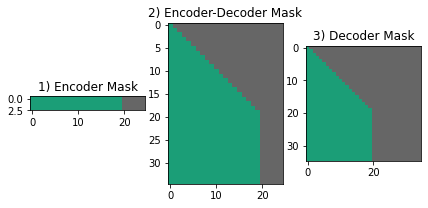

In [51]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

In [52]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

## 5. 훈련하기

1. 2 Layer를 가지는 Transformer를 선언하세요.
(하이퍼파라미터는 자유롭게 조절합니다.)
<br><br>
2. 논문에서 사용한 것과 동일한 Learning Rate Scheduler를 선언하고, 이를 포함하는 Adam Optimizer를 선언하세요. (Optimizer의 파라미터 역시 논문과 동일하게 설정합니다.)
<br><br>
3. Loss 함수를 정의하세요.
Sequence-to-sequence 모델에서 사용했던 Loss와 유사하되, Masking 되지 않은 입력의 개수로 Scaling하는 과정을 추가합니다. (트랜스포머가 모든 입력에 대한 Loss를 한 번에 구하기 때문입니다.)
<br><br>
4. train_step 함수를 정의하세요.
입력 데이터에 알맞은 Mask를 생성하고, 이를 모델에 전달하여 연산에서 사용할 수 있게 합니다.
<br><br>
5. 학습을 진행합니다.
매 Epoch 마다 제시된 예문에 대한 번역을 생성하고, 멋진 번역이 생성되면 그때의 하이퍼파라미터와 생성된 번역을 제출하세요!


## 6. 회고

## 7.루브릭 기준

1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다.
    - 데이터 정제, SentencePiece를 활용한 토큰화 및 데이터셋 구축의 과정이 지시대로 진행되었다.

2. Transformer 번역기 모델이 정상적으로 구동된다.
    - Transformer 모델의 학습과 추론 과정이 정상적으로 진행되어, 한-영 번역기능이 정상 동작한다.
    
3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.
    - 제시된 문장에 대한 그럴듯한 영어 번역문이 생성되며, 시각화된 Attention Map으로 결과를 뒷받침한다.